In [216]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, \
    mean_absolute_percentage_error, mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

import prophet

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as plt

import warnings
warnings.filterwarnings('ignore')

---

In [2]:
# Инициализация датасета
df = pd.read_csv('./data/train.csv', parse_dates=['date'], index_col=['date'])

/var/folders/df/dz8wtw0j7791hg98mrx_thxc0000gn/T/ipykernel_4790/239384023.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/train.csv', parse_dates=['date'], index_col=['date'])


In [3]:
df.rename(columns={'unit_sales':'sales'}, inplace=True)
display(df.head()) # Основная структура таблицы
print(f"Количество строк исходного датасета: {df.shape[0]}")

,id,store_nbr,item_nbr,sales,onpromotion
date,,,,,
2013-01-01,0,25,103665,7.0,NaN
2013-01-01,1,25,105574,1.0,NaN
2013-01-01,2,25,105575,2.0,NaN
2013-01-01,3,25,108079,1.0,NaN
2013-01-01,4,25,108701,1.0,NaN


Количество строк исходного датасета: 125497040


---

### Предподготовка данных

In [4]:
# Отфильтруем по 25 магазину и найдем сумму продаж
df_25_raw = df.query("store_nbr == 25")
df_25 = df_25_raw.groupby(by=df_25_raw.index)["sales"].sum()

# Зададим частоту равную дню и проведема интерполяцию для последующей декомпозиции
df_25 = df_25.asfreq(freq="D")
df_25 = df_25.interpolate(method="linear")
df_25 = pd.DataFrame(df_25)

display(df_25.head())
print(f"Пропуски: {df_25.isna().sum()}")

,sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


Пропуски: sales    0
dtype: int64


In [5]:
# Сохраним датасет для последующего быстрого открытия
df_25_raw.to_csv('./data/df_25_raw.csv')
df_25.to_csv("./data/df_25.csv")

In [6]:
# Откроем сохраненный датасет
df_25 = pd.read_csv("./data/df_25.csv", parse_dates=["date"], index_col=["date"])
df_25.head()

,sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


---

### Сезонное разложение ряда

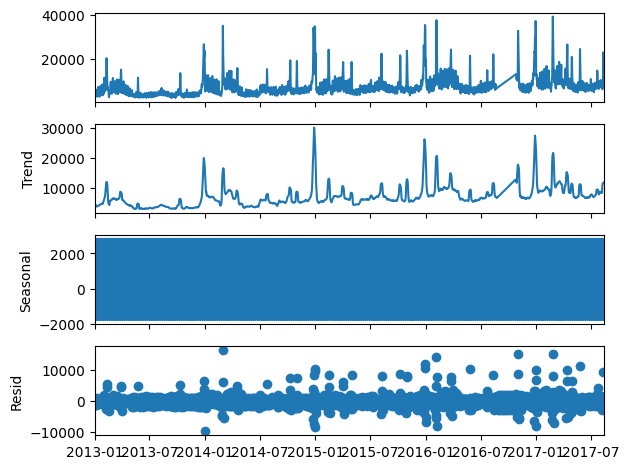

In [7]:
decomposition = seasonal_decompose(df_25)
decomposition.plot();

---

### Ответы на вопросы модуля 5

In [8]:
seasonal = decomposition.seasonal
trend = decomposition.trend

residuals = decomposition.resid
# residuals = residuals.dropna()

print(f"Количество элементов в исходном датасете: {df.shape[0]}")
print(f"Количество элементов в шумовой части: {residuals.shape[0]}")
print(f"Количество числовых элементов в шумовой части: {residuals.dropna().shape[0]}")
print(f"Количество элементов в сезонной части: {seasonal.shape[0]}")
print(f"Количество элементов в трендовой части: {trend.shape[0]}")

Количество элементов в исходном датасете: 125497040
Количество элементов в шумовой части: 1688
Количество числовых элементов в шумовой части: 1682
Количество элементов в сезонной части: 1688
Количество элементов в трендовой части: 1688


In [9]:
# Тест на стационарность
def adfuller_test(data, column='None'):
    test = adfuller(data[column])
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    if (
        test[0] > test[4]["5%"]
    ):  # проверка, больше ли критического полученное значение для нашего ряда
        print("ряд не стационарен")
    else:
        print("ряд стационарен")

adfuller_test(df_25, 'sales')

adf:  -5.001296622947667
p-value:  2.206239337839221e-05
Critical values:  {'1%': -3.4342906911169404, '5%': -2.8632805908715726, '10%': -2.5676966486957706}
ряд стационарен


---

### Формирование тренировочной и тестовой выборок

In [10]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(df_25["sales"])


for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 1667 TEST size: 7
TRAIN size: 1674 TEST size: 7
TRAIN size: 1681 TEST size: 7


---

### Ответы на вопросы модуля 8

In [11]:
# Реинициализируем датафрейм
data = df_25.copy()

In [12]:
# Постройте скользящее среднее c окном 5.
data["rolling_mean"] = data.rolling(window=5, min_periods=1).mean()
data.head(15)

,sales,rolling_mean
date,,
2013-01-01,2511.619,2511.6190
2013-01-02,5316.224,3913.9215
2013-01-03,4442.913,4090.2520
2013-01-04,4844.354,4278.7775
2013-01-05,5817.526,4586.5272
2013-01-06,3201.695,4724.5424
2013-01-07,2783.978,4218.0932
2013-01-08,2884.284,3906.3674
2013-01-09,3565.639,3650.6244


In [13]:
# Постройте скользящее квадратическое отклонение c окном 5.
data["rolling_std"] = data["sales"].rolling(window=5, min_periods=1).std()
data.head(15)

,sales,rolling_mean,rolling_std
date,,,
2013-01-01,2511.619,2511.6190,NaN
2013-01-02,5316.224,3913.9215,1983.155214
2013-01-03,4442.913,4090.2520,1435.175821
2013-01-04,4844.354,4278.7775,1230.983569
2013-01-05,5817.526,4586.5272,1268.873437
2013-01-06,3201.695,4724.5424,994.665070
2013-01-07,2783.978,4218.0932,1233.965510
2013-01-08,2884.284,3906.3674,1354.005326
2013-01-09,3565.639,3650.6244,1249.257405


In [14]:
# Вычисление линий Боллинджера с окном в 30.
data.drop(["rolling_mean", "rolling_std"], axis=1, inplace=True)

# Окно скольжения
window = 30
data["rolling_mean"] = data["sales"].rolling(window=window, min_periods=1).mean()

data["rolling_std"] = data["sales"].rolling(window=window, min_periods=1).std()

data.dropna(inplace=True)

data.head()

,sales,rolling_mean,rolling_std
date,,,
2013-01-02,5316.224,3913.921500,1983.155214
2013-01-03,4442.913,4090.252000,1435.175821
2013-01-04,4844.354,4278.777500,1230.983569
2013-01-05,5817.526,4586.527200,1268.873437
2013-01-06,3201.695,4355.721833,1267.934755


In [15]:
num_std = 3  # Количество стандартных отклонений
data["upper_band"] = (
    data["rolling_mean"] + num_std * data["rolling_std"]
)  # Верхняя полоса
data["lower_band"] = (
    data["rolling_mean"] - num_std * data["rolling_std"]
)  # Нижняя полоса

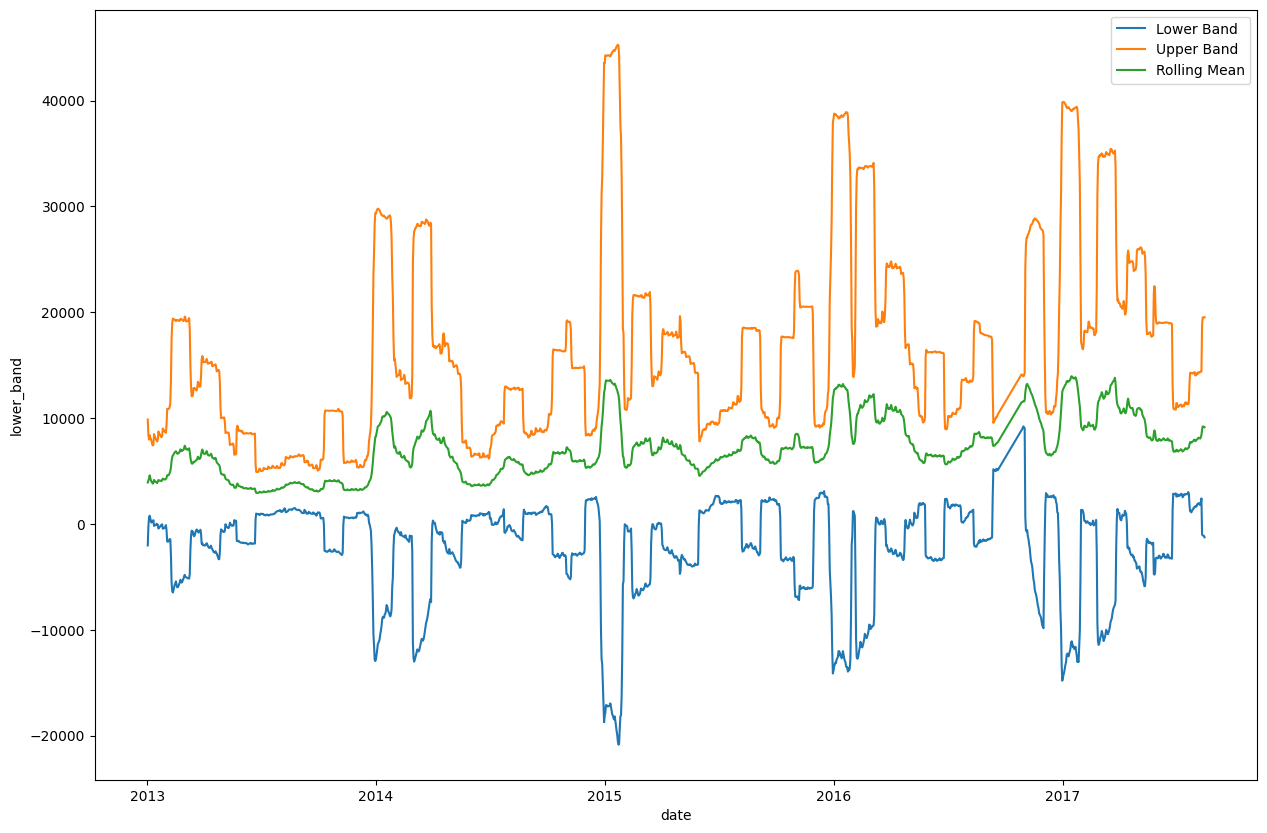

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(data["lower_band"], ax=axes, label="Lower Band")
sns.lineplot(data["upper_band"], ax=axes, label="Upper Band")
sns.lineplot(data["rolling_mean"], ax=axes, label="Rolling Mean")
axes.legend()
plt.show()

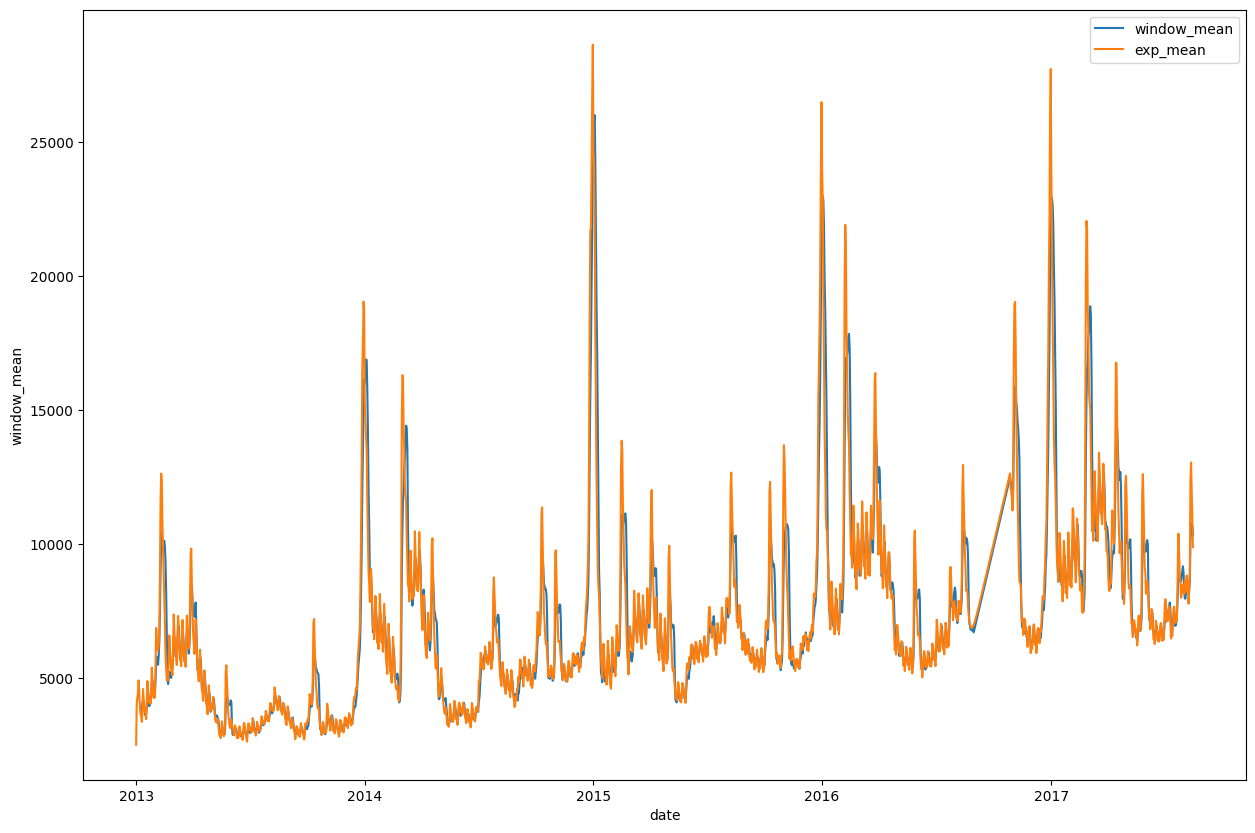

In [17]:
# Реинициализируем датафрейм
data = df_25.copy()

# Постройте оконное среднее с окном в 10 точек.
data["window_mean"] = data["sales"].rolling(window=10).mean()

# Постройте экспоненциально среднее с окном в 7 точек (span=7).
data["exp_mean"] = data["sales"].ewm(span=7).mean()

# Отобразите их на отдельном графике.
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

sns.lineplot(data["window_mean"], ax=axes, label="window_mean")
sns.lineplot(data["exp_mean"], ax=axes, label="exp_mean")
axes.legend()
plt.show()

In [18]:
# Реинициализируем датафрейм
data = df_25.copy()

# Напишите свою скользящую функцию, которая будет являться средним арифметическим
# между максимальным и минимальным значением unit_sales, используя окно 10.

# Через лямбда функцию
data["custom_rolling_mean_lambda"] = (
    data["sales"]
    .rolling(window=10)
    .apply(lambda x: np.mean(np.array([np.max(x), np.min(x)])))
)


# Через обычную
def custom_rolling(array_data):
    return np.mean(np.array([np.max(array_data), np.min(array_data)]))


data["custom_rolling_mean"] = data["sales"].rolling(window=10).apply(custom_rolling)


display(data.head(15))
display(data.tail(15))

,sales,custom_rolling_mean_lambda,custom_rolling_mean
date,,,
2013-01-01,2511.619,NaN,NaN
2013-01-02,5316.224,NaN,NaN
2013-01-03,4442.913,NaN,NaN
2013-01-04,4844.354,NaN,NaN
2013-01-05,5817.526,NaN,NaN
2013-01-06,3201.695,NaN,NaN
2013-01-07,2783.978,NaN,NaN
2013-01-08,2884.284,NaN,NaN
2013-01-09,3565.639,NaN,NaN


,sales,custom_rolling_mean_lambda,custom_rolling_mean
date,,,
2017-08-01,7937.218,9608.7390,9608.7390
2017-08-02,10136.327,8163.0020,8163.0020
2017-08-03,6873.802,8163.0020,8163.0020
2017-08-04,9276.890,8163.0020,8163.0020
2017-08-05,9910.015,8163.0020,8163.0020
2017-08-06,8064.109,8505.0645,8505.0645
2017-08-07,7527.348,8505.0645,8505.0645
2017-08-08,6025.029,8080.6780,8080.6780
2017-08-09,9707.858,8080.6780,8080.6780


In [19]:
# Постройте скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 (span=10). 
# Укажите индексы датафрейма, на которых одно скользящее пересекается с другим. 
# Для этого вычтите из одно скользящего среднего другое, возьмите знак этой разности (np.sign), 
# продифференциируйте его (diff()) и оставьте только те точки, где результат дифференциирования не равен нулю.

# Реинициализируем датафрейм
data = df_25.copy()

data['rolling_mean'] = data['sales'].rolling(window=50, min_periods=1).mean()
data['exp_mean'] = data['sales'].ewm(span=10).mean()

# Вычисляем пересечения
crossings = np.sign(data['rolling_mean'] - data['exp_mean']).diff()
crossings = crossings[crossings != 0]

# Выводим индексы датафрейма, на которых одно скользящее пересекается с другим
print(crossings.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-07', '2013-01-12',
               '2013-01-14', '2013-01-18', '2013-02-20', '2013-02-22',
               '2013-02-26', '2013-03-02',
               ...
               '2017-04-19', '2017-04-29', '2017-05-02', '2017-05-26',
               '2017-05-30', '2017-06-03', '2017-06-05', '2017-07-02',
               '2017-07-04', '2017-07-15'],
              dtype='datetime64[ns]', name='date', length=136, freq=None)


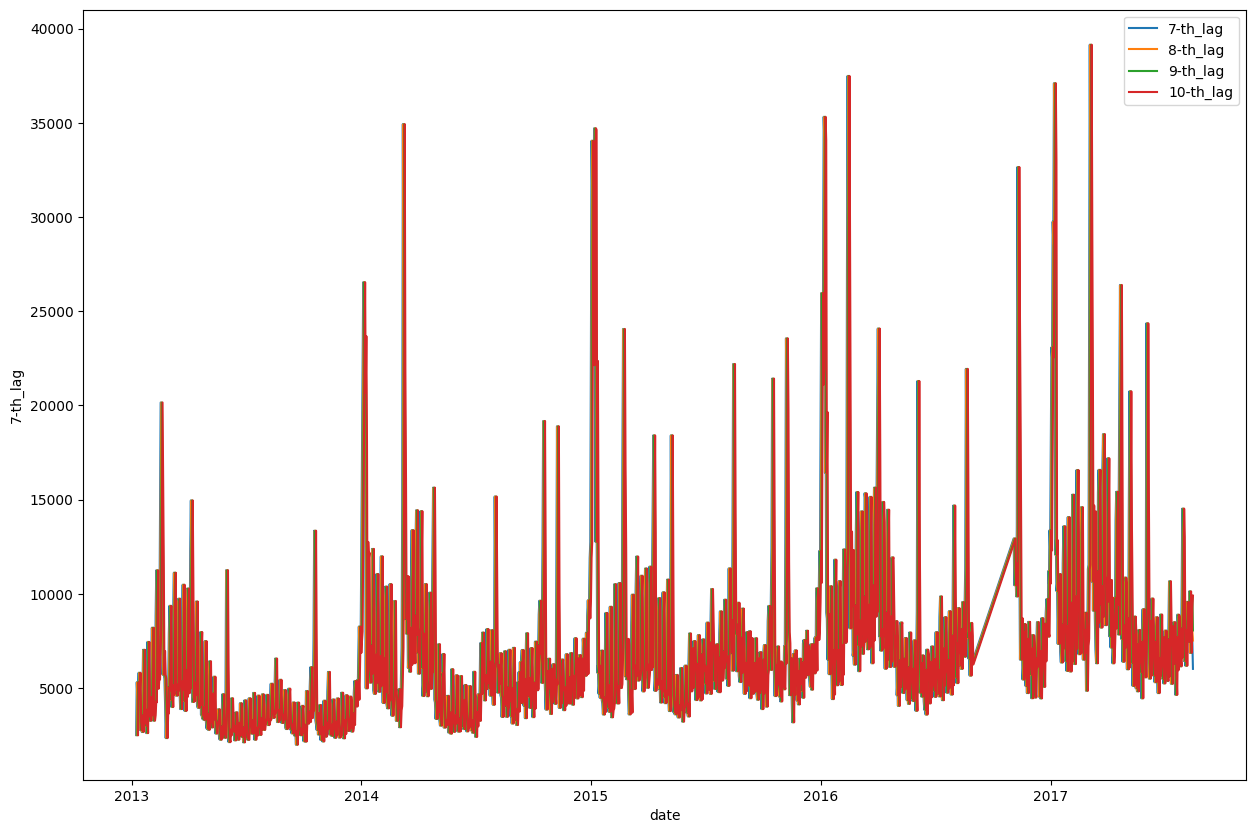

In [20]:
# Получите лаговые факторы с 7-го по 10-й предыдущих дня (лаг7, лаг8, лаг9, лаг10) и отобразите на графике.

# Реинициализируем датафрейм
data = df_25.copy()

data["7-th_lag"] = data["sales"].shift(periods=7)
data["8-th_lag"] = data["sales"].shift(periods=8)
data["9-th_lag"] = data["sales"].shift(periods=9)
data["10-th_lag"] = data["sales"].shift(periods=10)

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(data["7-th_lag"], ax=axes, label = "7-th_lag")
sns.lineplot(data["8-th_lag"], ax=axes, label = "8-th_lag")
sns.lineplot(data["9-th_lag"], ax=axes, label = "9-th_lag")
sns.lineplot(data["10-th_lag"], ax=axes, label = "10-th_lag")

axes.legend()
plt.show()

---

### Ответы для модуля 10

In [159]:
# Сразу создадим функцию для расчета метрик и визуализации
def forecast_result(y_train, y_test, forecast, column="sales"):
    print(f"Forecast MSE: {mean_squared_error(y_test, forecast).round(2)}")
    print(f"Forecast MAE: {mean_absolute_error(y_test, forecast).round(2)}")
    print(
        f"Forecast MAPE: {mean_absolute_percentage_error(y_test, forecast).round(2)}%"
    )

    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    sns.lineplot(forecast[column], ax=axes, label="Forecast", c="red")
    sns.lineplot(y_train[column].tail(40), ax=axes, label="Historical_data", c="green")
    sns.lineplot(y_test[column], ax=axes, label="Real_data")
    axes.legend()
    plt.show()

In [155]:
# Выберите продукт с номером 103501 (item_nbr) и приведите данные
# к виду временного ряда с группировкой по дате и агрегацией .sum()['unit_sales'].
data = pd.DataFrame(df.query("item_nbr == 103501")["sales"])
data = data.groupby(by=data.index).sum()
data.head()

,sales
date,
2013-01-02,185.0
2013-01-03,153.0
2013-01-04,155.0
2013-01-05,160.0
2013-01-06,173.0


In [156]:
# Проведите тест Адфуллера. Стационарен ли ряд?
adfuller_test(data, "sales")

adf:  -4.154403058014598
p-value:  0.0007863083913836962
Critical values:  {'1%': -3.4344462031760283, '5%': -2.8633492329988335, '10%': -2.5677331999518147}
ряд стационарен


Forecast MSE: 223.84
Forecast MAE: 11.81
Forecast MAPE: 0.15%


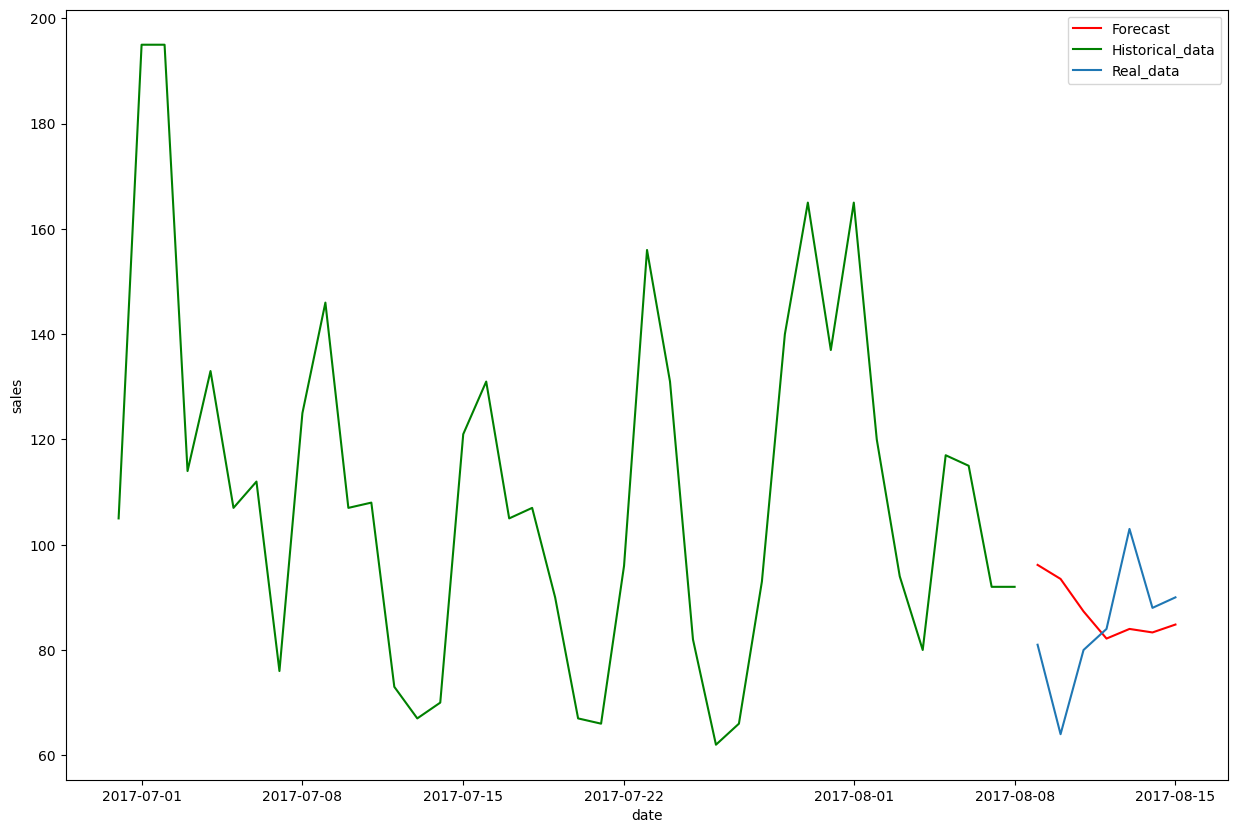

In [162]:
# Постройте прогноз методом скользящего среднего с окном 6, как в ноутбуке выше.
# Посчитайте метрики MSE, MAE, MAPE.

# Немного модифицируем функцию SMA-прогноза из модуля
def moving_average_forecast(series, window_size, forecast_size):
    forecast = []
    for time in range(len(series) - window_size + 1):
        forecast.append(np.mean(series[time : time + window_size]))
    return np.array(forecast)[-forecat_size:]

# Укажем горизонт планирования и сформируем train/test 
forecat_size = 7
y_train = data.iloc[: len(data) - forecat_size]
y_test = data.iloc[-forecat_size:]

# Сформируем прогноз и свернем его в датафрейм 
sma_forecast = moving_average_forecast(data, window_size=6, forecast_size=forecat_size)
sma_forecast = pd.DataFrame(sma_forecast, index=y_test.index, columns=y_test.columns)

# Выведем результаты
forecast_result(y_train, y_test, sma_forecast)

### Хороший результат если целью было планирование например среднего показателя за планируемый период

In [163]:
# Сделайте лаги с 1 по 6. 
predict_size=7

for i in range(1, predict_size):
    data[f'shift_{i}'] = data['sales'].shift(i)

data.dropna(inplace=True)
data.head(10)

,sales,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6
date,,,,,,,
2013-01-08,103.0,98.0,173.0,160.0,155.0,153.0,185.0
2013-01-09,71.0,103.0,98.0,173.0,160.0,155.0,153.0
2013-01-10,83.0,71.0,103.0,98.0,173.0,160.0,155.0
2013-01-11,91.0,83.0,71.0,103.0,98.0,173.0,160.0
2013-01-12,118.0,91.0,83.0,71.0,103.0,98.0,173.0
2013-01-13,128.0,118.0,91.0,83.0,71.0,103.0,98.0
2013-01-14,97.0,128.0,118.0,91.0,83.0,71.0,103.0
2013-01-15,127.0,97.0,128.0,118.0,91.0,83.0,71.0
2013-01-16,102.0,127.0,97.0,128.0,118.0,91.0,83.0


Forecast MSE: 148.56
Forecast MAE: 10.78
Forecast MAPE: 0.13%


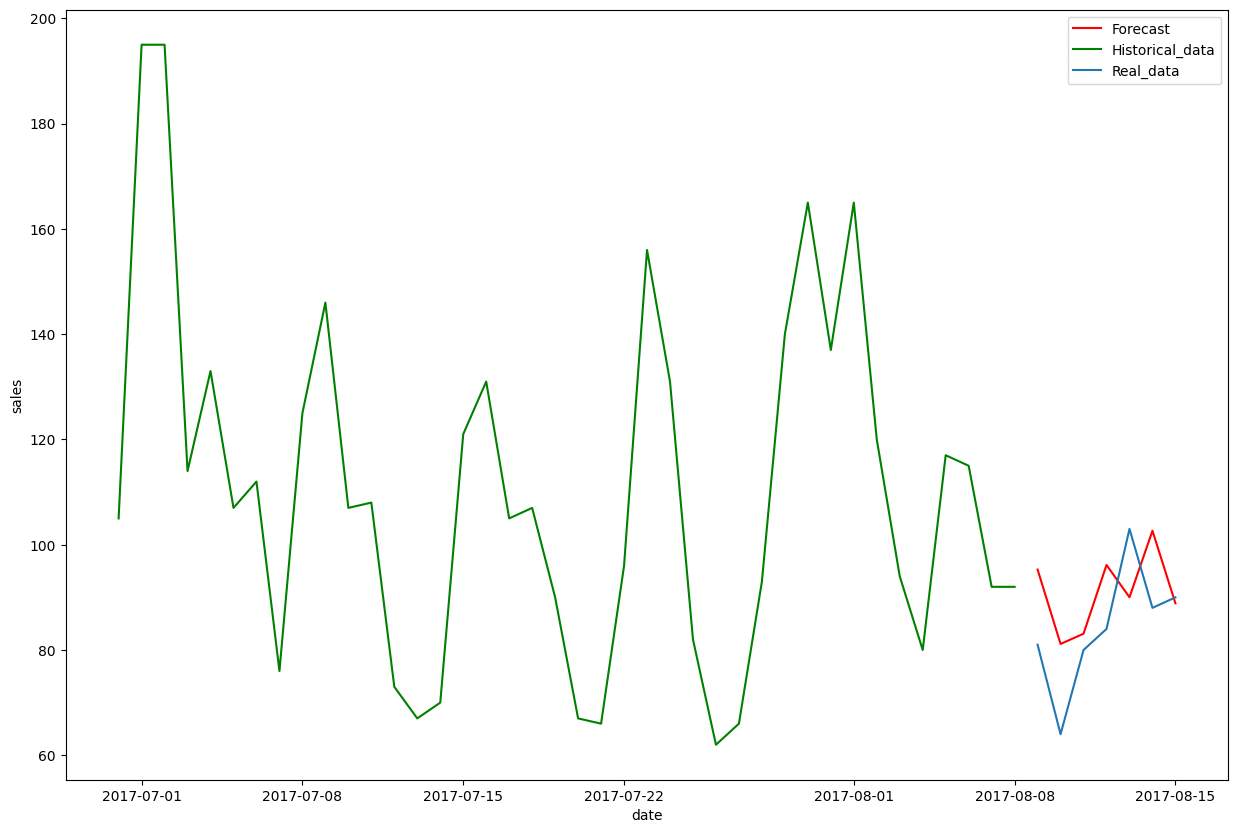

In [164]:
# Отложите 1-2 последних дня в тестовую выборку для совершения предсказания.
# Сделайте прогноз линейной регрессией, посчитайте значения метрик MSE, MAE, MAPE.

# Так как я прогнозировал скользящимм средним неделю, то и в линейной регрессии
# я решил взять этот интервал для корректности сравнения моделей.

# Формируем трейн/тест
x_train, y_train = (
    data[:-predict_size].drop(["sales"], axis=1),
    pd.DataFrame(data[:-predict_size]["sales"]),
)

x_test, y_test = (
    data[-predict_size:].drop(["sales"], axis=1),
    pd.DataFrame(data[-predict_size:]["sales"]),
)

# Обучаем модель линейной регрессии
lr = LinearRegression().fit(x_train, y_train)

# Формируем прогноз
lr_forecast = pd.DataFrame(
    lr.predict(x_test), index=y_test.index, columns=y_test.columns
)

# Выводим результаты
forecast_result(y_train, y_test, lr_forecast)


### Хороший результат, но есть подозрение, что закралась утечка данных

In [175]:
# Реинициализируем датафрейм
data = data['sales']

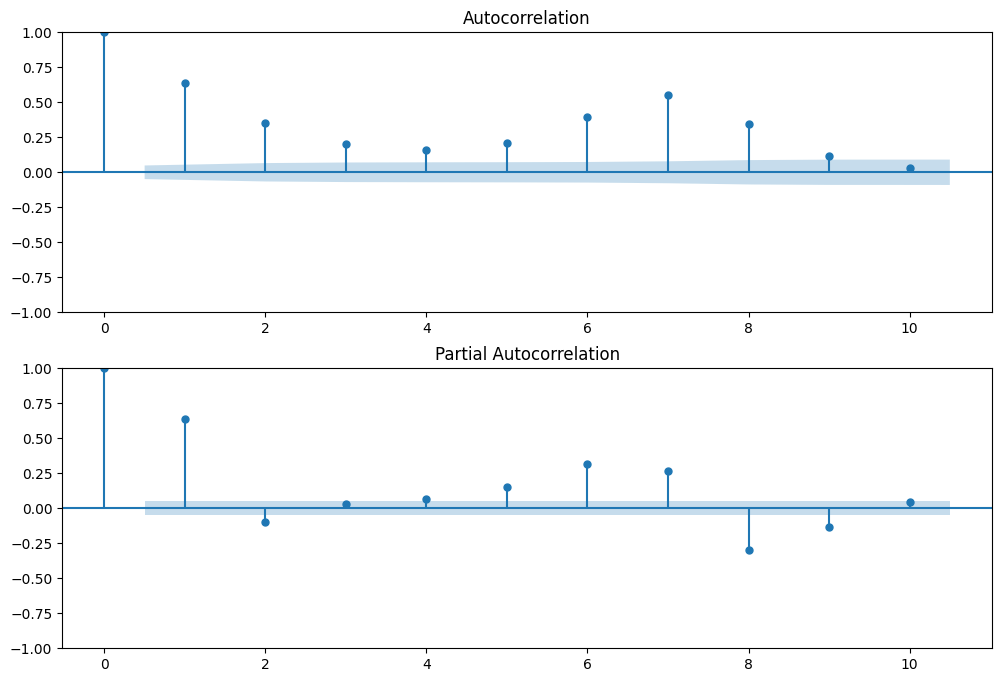

In [178]:
# Определите p и q
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=10, ax=ax2)

In [203]:
# Для определения оптимальных значений параметров p и q в модели ARIMA можно
# использовать графики автокорреляции (ACF) и частичной автокорреляции (PACF).

# Чтобы определить параметр q (количество лагов в модели скользящего среднего),
# можно посмотреть на график ACF и определить последний значимый сезонный лаг,
# после которого автокорреляции становятся незначительными.

# Для определения параметра p (количество лагов в модели авторегрессии) можно
# посмотреть на график PACF и определить последний значимый сезонный лаг, после которого
# частичные автокорреляции становятся незначительными.


p_manual = 7
d_manual = 0  # Исходя из теста на стационарность
q_manual = 8

In [190]:
# Посмотрим будут ли параметры, подобранные pm_autoarima, более оптимальными
forecast_horizon = 7
train, test = (data.iloc[: len(data) - forecast_horizon], data.tail(forecast_horizon))

model_pm_arima = pm.auto_arima(
    train,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=20,
    max_q=20,
    m=7,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

forecasts, conf_int = model_pm_arima.predict(n_periods=len(test), return_conf_int=True)

model_pm_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.58 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=15630.195, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=14988.673, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=14707.874, Time=0.78 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=15492.199, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=14707.142, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=14946.695, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=14696.010, Time=1.55 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=14857.224, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=14689.302, Time=1.82 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=14693.391, Time=1.27 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=14823.488, Time=1.22 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=inf, Time=4.86 sec
 ARIMA(0,1,2)(2,1,2)[7]             : AIC=14626.278, Time=2.01 sec
 ARIMA(0,1,2)(1,1,2)[7]        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1612
Model:             SARIMAX(0, 1, 3)x(2, 1, [1, 2], 7)   Log Likelihood               -7286.992
Date:                                Tue, 16 Jan 2024   AIC                          14589.984
Time:                                        13:30:49   BIC                          14633.026
Sample:                                             0   HQIC                         14605.965
                                               - 1612                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3767      0.020    -18.535      0.000      -0.417      -0.337
ma.L2         -0.2194      0.024     -9.139      0.000      -0.266      -0.172
ma.L3         -0.1774      0.024     -7.534      0.000      -0.224      -0.131
ar.S.L7       -0.6353      0.142     -4.470      0.000      -0.914      -0.357
ar.S.L14       0.0886      0.039      2.279      0.023       0.012       0.165
ma.S.L7       -0.1934      0.140     -1.378      0.168      -0.468       0.082
ma.S.L14      -0.5222      0.107     -4.869      0.000      -0.732      -0.312
sigma2       514.1029     12.830     40.071      0.000     488.957     539.249
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               352.05
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.51
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [204]:
# Полученные результаты
p_auto = model_pm_arima.get_params()["order"][0]
d_auto = model_pm_arima.get_params()["order"][1]
q_auto = model_pm_arima.get_params()["order"][2]

In [210]:
# Постройте ARIMA, сравните метрики.
arima_manual = ARIMA(y_train.values.reshape(-1), order=(p_manual, d_manual, q_manual))

arima_auto = ARIMA(y_train.values.reshape(-1), order=(p_auto, d_auto, q_auto))


arima_manual_pred = arima_manual.fit().predict(
    start=len(y_train), end=len(data) - 1, dynamic=False
)
arima_manual_pred = pd.DataFrame(
    arima_manual_pred, index=y_test.index, columns=y_test.columns
)


arima_auto_pred = arima_auto.fit().predict(
    start=len(y_train), end=len(data) - 1, dynamic=False
)

arima_auto_pred = pd.DataFrame(
    arima_auto_pred, index=y_test.index, columns=y_test.columns
)

Forecast MSE: 304.88
Forecast MAE: 13.93
Forecast MAPE: 0.16%


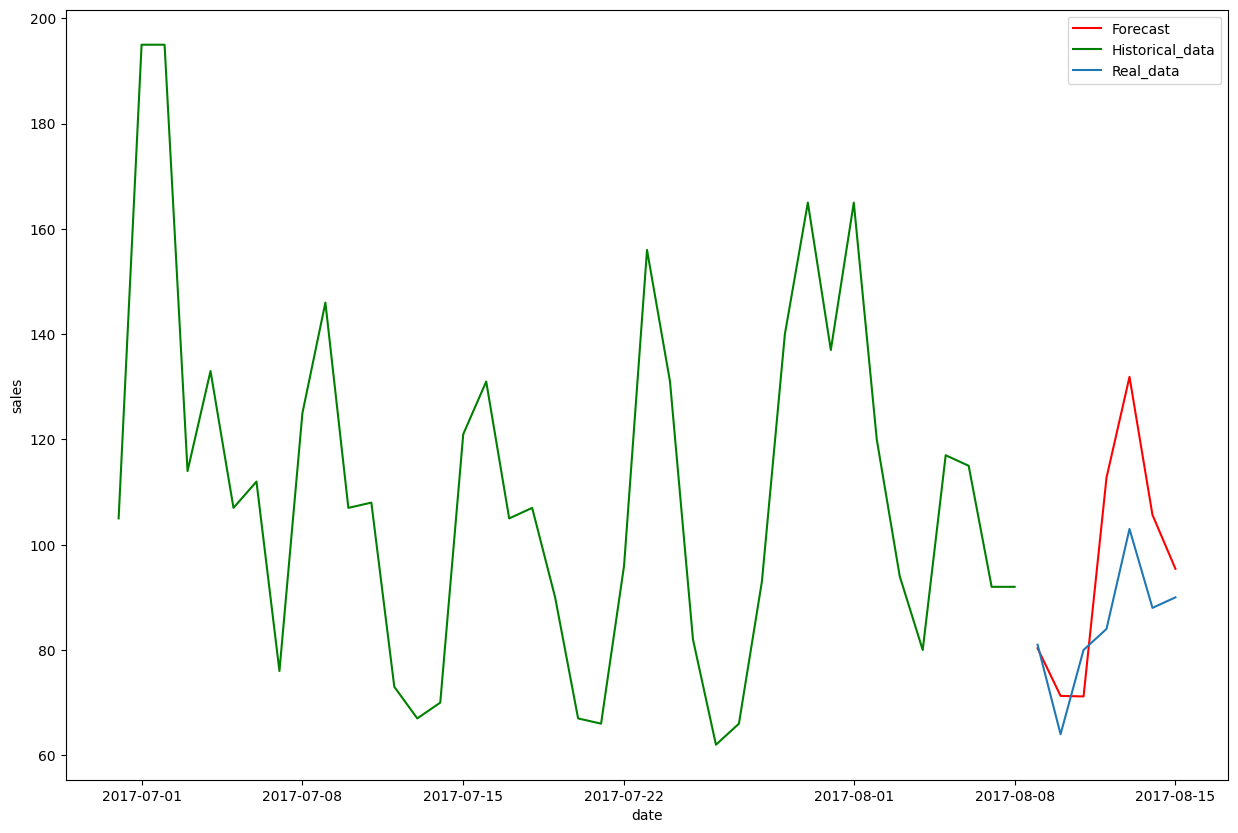

In [212]:
forecast_result(y_train, y_test, arima_manual_pred)

Forecast MSE: 613.18
Forecast MAE: 22.35
Forecast MAPE: 0.29%


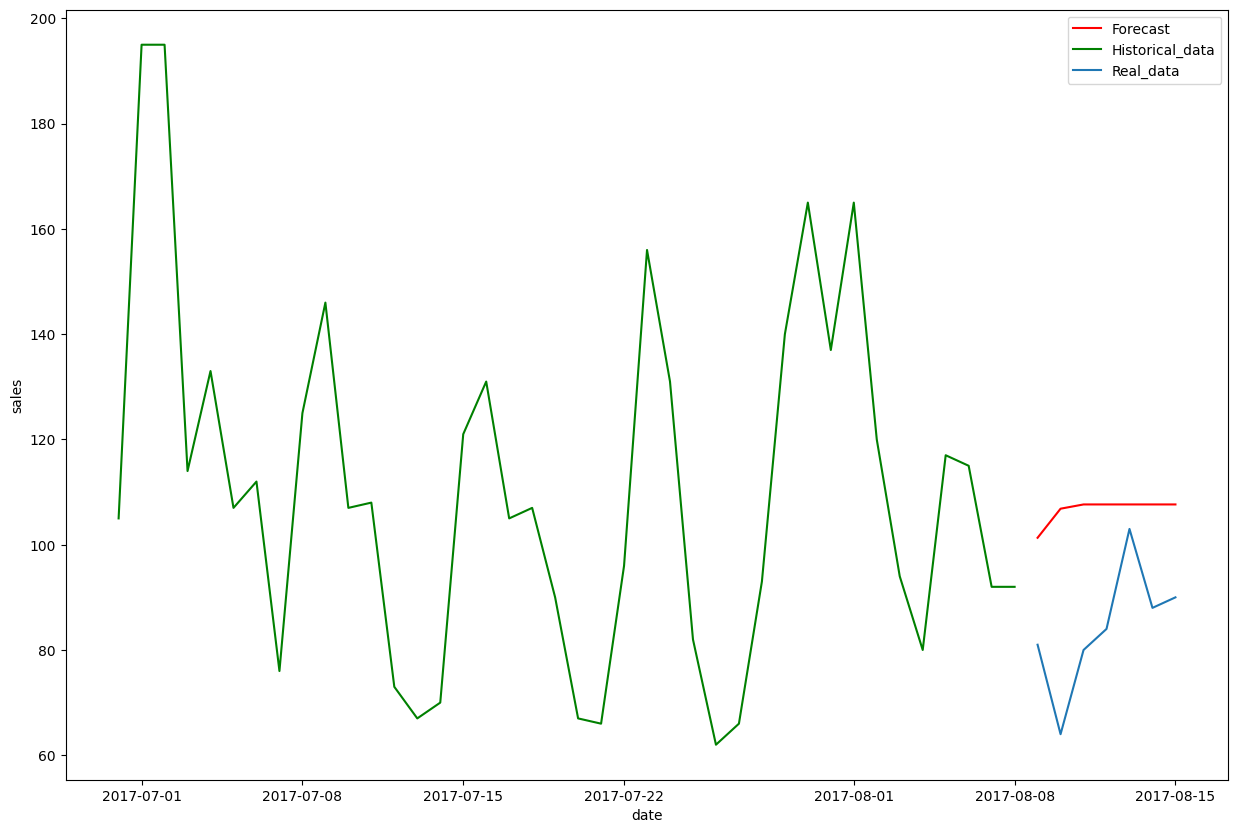

In [213]:
forecast_result(y_train, y_test, arima_auto_pred)

### На удивление визуальный анализ дал лучший результат, возможно дело в том что модель автоаримы была не корректно инициализирована и потому сходится к константе.

### Мой выбор падает на ARIMA, т.к. модель хорошо уловила форму реальных данных, показала хороший результат на метрихах.

---